# Load packages

In [1]:
import numpy as np
import torch
import sys
from utils import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5170877, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5829122, 28)
dataset_P = MatConvert(dataset_P, device, dtype)
dataset_Q = MatConvert(dataset_Q, device, dtype)

In [3]:
features = ['lepton pT', 
            'lepton eta', 
            'lepton phi', 
            'missing energy magnitude', 
            'missing energy phi', 
            'jet 1 pt', 
            'jet 1 eta', 
            'jet 1 phi', 
            'jet 1 b-tag', 
            'jet 2 pt', 
            'jet 2 eta', 
            'jet 2 phi', 
            'jet 2 b-tag', 
            'jet 3 pt', 
            'jet 3 eta', 
            'jet 3 phi', 
            'jet 3 b-tag', 
            'jet 4 pt', 
            'jet 4 eta',
            'jet 4 phi', 
            'jet 4 b-tag', 
            'm_jj',   # 22
            'm_jjj',  # 23
            'm_lv',   # 24
            'm_jlv',  # 25
            'm_bb',   # 25
            'm_wbb',  # 26
            'm_wwbb'] # 27
# 2 decimal print
# feture_mean = np.round(np.mean(dataset, axis=0), 2)
# print('mean: ', feture_mean)


# Use MMD method to plot 
modify n_train and path_LFI to change the checkpoint.

In [4]:
# Load the trained model
n_train = 1300000
path_LFI = './Res_Net/checkpoint1300000/0/'
model = DN(300, 100).to(device)
another_model = another_DN().to(device)
try:
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path_LFI)
except:
    print('No model found...')
    print('Please first run Res_Net/MMD_M.py to train the model and make sure that path_LFI is a valid checkpoint')
    raise Exception('No model found. Please first run ./Res_Net/MMD_M.py to train the model and make sure that path_LFI is a valid checkpoint')

thres= 0.19485165245898134 ,max= 0.2710693 ,min= -0.2139079
In get_thres(), p-thres.png saved


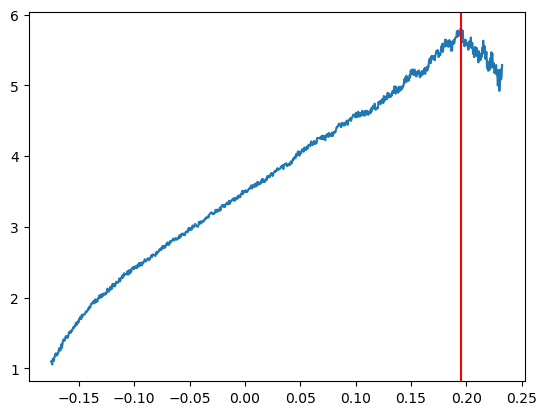

(0.19485165245898134, 0.3197, 0.9818)

In [5]:
# Set up $X^{test}$ and $Y^{test}$ to compute score function and threshold
n_test = 10000
X_test = dataset_P[np.random.choice(n_train, n_test, replace=False)]
Y_test = dataset_Q[np.random.choice(n_train, n_test, replace=False)]
thres, sig_to_sig, back_to_back = get_thres_at_once(X_test, Y_test, X_test, Y_test,
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, 
                    batch_size = 10000)

thres, sig_to_sig, back_to_back

In [6]:
# Compute distribution of score
n_eval = 1000000
X_eval = dataset_P[n_train+n_test : n_train+n_test+n_eval]
Y_eval = dataset_Q[n_train+n_test : n_train+n_test+n_eval]
XY_eval = torch.concatenate((X_eval, Y_eval), axis=0)
phi_Z = torch.zeros(2*n_eval, dtype=dtype, device=device)
batch_size = 10000
for i in range(n_eval//batch_size):
    phi_Z[i*batch_size:(i+1)*batch_size] = compute_score_func(XY_eval[i*batch_size:(i+1)*batch_size], X_test, Y_test, 
                                                            model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst)
idx = phi_Z > thres

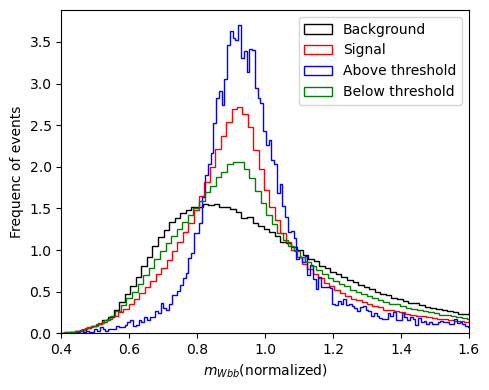

In [7]:
# Plot
feature = 26
Background = X_eval[:, feature].cpu().numpy()
Signal = Y_eval[:, feature].cpu().numpy()
Conditioned_to_signal = XY_eval[idx, feature].cpu().numpy()
Conditioned_to_background = XY_eval[~idx, feature].cpu().numpy()
bins = 500
alpha = 1
plt.figure(figsize=(5, 4), dpi=100)
plt.hist(Background, bins=bins, alpha=alpha, label='Background', density=True, color='black', histtype='step')
plt.hist(Signal, bins=bins, alpha=alpha, label='Signal', density=True, color='red', histtype='step')
plt.hist(Conditioned_to_signal, bins=bins, alpha=alpha, label='Above threshold', density=True, color='blue', histtype='step')
plt.hist(Conditioned_to_background, bins=bins, alpha=alpha, label='Below threshold', density=True, color='green', histtype='step')
plt.xlabel('$m_{Wbb}$(normalized)')
plt.ylabel('Frequenc of events')
plt.xlim(0.4, 1.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig('./kernel m_wbb.pdf', dpi=300)

# Use Scheffe to plot
modify n_train and path_Scheffe to change the checkpoint.

In [8]:
n_train = 1300000
path_Scheffe = './Scheffe/checkpoint1300000/0/'
model = Classifier(300, 5, True).to(device)
another_model = another_DN().to(device)
try:
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path_Scheffe)
except:
    print('No model found...')
    print('Please first run Res_Net/MMD_M.py to train the model and make sure that path_LFI is a valid checkpoint')
    raise Exception('No model found. Please first run ./Res_Net/MMD_M.py to train the model and make sure that path_LFI is a valid checkpoint')

No model found...
Please first run Res_Net/MMD_M.py to train the model and make sure that path_LFI is a valid checkpoint


Exception: No model found. Please first run ./Res_Net/MMD_M.py to train the model and make sure that path_LFI is a valid checkpoint

thres= 0.8972723334194782 ,max= 0.99929094 ,min= 0.0001086773
In get_thres(), p-thres.png saved


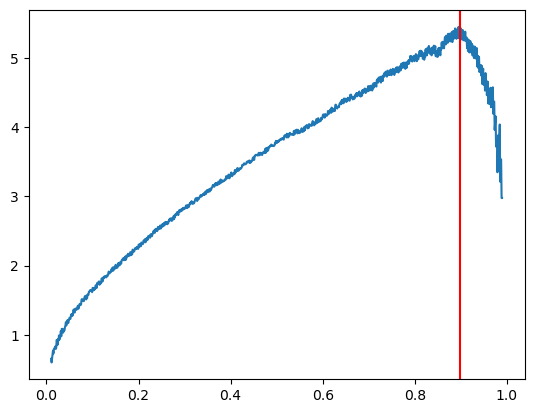

(0.8972723334194782, 0.24355, 0.9883)

In [ ]:
n_test = 20000
X_test = dataset_P[n_train:n_train+n_test]
Y_test = dataset_Q[n_train:n_train+n_test]
thres, sig_to_sig, back_to_back = get_thres_at_once(X_test, Y_test, X_test, Y_test, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, 
                    batch_size = 5000)
thres, sig_to_sig, back_to_back

In [ ]:
n_eval = 1000000
X_eval = dataset_P[n_train+n_test : n_train+n_test+n_eval]
Y_eval = dataset_Q[n_train+n_test : n_train+n_test+n_eval]
XY_eval = torch.concatenate((X_eval, Y_eval), axis=0)
phi_Z = torch.zeros(2*n_eval, dtype=dtype, device=device)
batch_size = 10000
for i in range(n_eval//batch_size+1):
    phi_Z[i*batch_size:(i+1)*batch_size] = compute_score_func(XY_eval[i*batch_size:(i+1)*batch_size], X_test, Y_test, 
                                                            model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst)
idx = phi_Z > thres

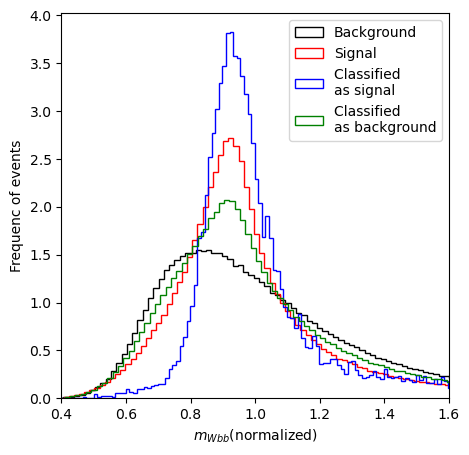

In [ ]:

feature = 26
Background = X_eval[:, feature].cpu()
Signal = Y_eval[:, feature].cpu()
Conditioned_to_signal = XY_eval[idx, feature].cpu()
Conditioned_to_background = XY_eval[~idx, feature].cpu()
bins = 500
alpha = 1
plt.figure(figsize=(5, 5), dpi=100)
plt.hist(Background, bins=bins, alpha=alpha, label='Background', density=True, color='black', histtype='step')
plt.hist(Signal, bins=bins, alpha=alpha, label='Signal', density=True, color='red', histtype='step')
plt.hist(Conditioned_to_signal, bins=bins, alpha=alpha, label='Above threshold', density=True, color='blue', histtype='step')
plt.hist(Conditioned_to_background, bins=bins, alpha=alpha, label='Below threshold', density=True, color='green', histtype='step')
plt.xlabel('$m_{Wbb}$(normalized)')
plt.ylabel('Frequenc of events')
plt.xlim(0.4, 1.6)
plt.legend(loc='upper right', fontsize=10)
plt.savefig('./Scheffe m_wbb.pdf', dpi=300)